# 1 Realizable least squares 
$$ y = w^\top_* x
$$
We further assume that $x \sim N(u,\Sigma)$. To reterive $w_*$, we solve the following optimization problem: 
$$
\arg\min_w \left( f(w):=\frac 12 w^\top E[xx^\top] w - w^\top E[yx] \right)
$$
Here we investigate the convergence of SGD and stochastic heavy ball in the above setting. Note that the gradient of the above objective is: 
$$\nabla f_x(w) = x x^\top w - y x, \quad \nabla f(w) = E_x[\nabla f_x(w)]$$

In [34]:
import numpy as np
np.set_printoptions(precision=64)
from collections import deque
%matplotlib inline
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import math
import scipy as sc
def get_cosine_basis(N):
    C = np.zeros((N, N))
    S = np.zeros((N, N))
    ns = np.arange(N)
    one_cycle = 2 * np.pi * ns / N
    for k in range(N):
        t_k = k * one_cycle
        C[k, :] = np.cos(t_k)
        S[k, :] = np.sin(t_k)
    return C

In [40]:
# X:(n*d) matrix containing data
alpha_data = 100
n = pow(10,5)
d = 2
X = np.zeros((n,d))
X[:,0] = 2*(np.random.randint(0,2,n)-0.5)
# Z = np.random.rand(n)
# inds = Z>pow(alpha_data,-4)
# X[inds,1] = 0
X[:,1]  = 2*(np.random.rand(n)-0.5)*alpha_data


In [4]:
# covariance of the data is ill condition
X.T @ X/float(n)

array([[ 1.00000000e+00, -3.40769751e-01],
       [-3.40769751e-01,  3.31841818e+03]])

In [5]:
8.32349430e+02/3.33105860e-01 - 2.32799333e+03

170.7601593562067

In [6]:
X

array([[ -1.        ,  54.77108711],
       [  1.        , -17.52708559],
       [  1.        ,  67.87471169],
       ...,
       [  1.        ,  60.95096412],
       [  1.        ,  60.70465241],
       [ -1.        ,  -0.55559125]])

In [7]:
# checking the statatiscal condition of Jain's matrix (scales with alpha^2)
D = X.T @ X/float(n)
X1 = X 
for i in range(n): 
  X1[i,:] = X1[i,:]*math.sqrt(np.dot(np.dot(X1[i,:],np.linalg.inv(D)),X1[i,:]))
  
X1.T @ X1/float(n)

array([[ 2.00000000e+00, -3.49463761e-01],
       [-3.49463761e-01,  9.29929730e+03]])

In [8]:
X

array([[ -1.37579937,  75.35402737],
       [  1.04355749, -18.29052137],
       [  1.54994491, 105.2020636 ],
       ...,
       [  1.460174  ,  88.99901287],
       [  1.45706116,  88.45039136],
       [ -1.00012106,  -0.55565851]])

In [35]:
D = X.T @ X/float(n)
X1 = X 
for i in range(n): 
 X1[i,:] = X1[i,:]*np.linalg.norm(X1[i,:])
  
X1.T @ X1/float(n)

array([[1.0119750150493108e-03, 7.7664646440068238e-04],
       [7.7664646440068238e-04, 3.0323442626972006e+00]])

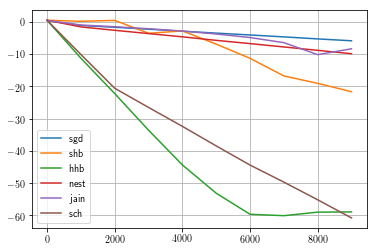

In [41]:
####################################
   ### EMERGENCY ### THIS GUY ###
####################################

#generating data 
# alpha_data = 10
# n = pow(10,5)
# d = 2
# X = alpha_data*np.ones((n,d))
# X[:,1] = 2*(np.random.randint(2,size=n)-0.5)
# Z = np.random.rand(n)
# inds = Z>pow(alpha_data,-2)
# X[inds,1] = 0
# Y = 2*(np.random.randint(2,size=n)-0.5)
# X[:,1] = Y * X[:,1] 

wst = np.random.randn(d)
wst = wst/np.linalg.norm(wst)
# wst = np.zeros(d)
# mu = np.random.randn(d)
mu = np.zeros(d)
w_sgd = np.random.randn(d)
w_sgd = w_sgd/np.linalg.norm(w_sgd)
w_shb = w_sgd.copy()
w_hhb = w_sgd.copy()


T = 10000
ss = 0.0001

def get_obj(w):
  return 0.5*(w.transpose() @ S @ w) - w.transpose() @ S @ wst
dis_sgd = []
dis_shb = []
dis_hhb = []
dis_net = []
itrs = []
pastw = w_shb.copy()
pastwh = w_hhb.copy()
w_net = w_shb.copy()
y_net = w_net.copy()
betah = 1
y_past = y_net.copy()
beta = 0.9*betah
alpha = 0.9
I = np.eye(d)

w_jain = w_sgd.copy()
y_jain = w_jain.copy()
z_jain = w_jain.copy()
v_jain = w_jain.copy()

mu_jain =0.3
KK_jain = 1/alpha_data/alpha_data*10
beta_jain = 1/9*np.power(KK_jain,1)
alpha_jain = 3*np.sqrt(5)/np.power(KK_jain,1)/(1+3*np.sqrt(5)/np.power(KK_jain,1))

jain_list = deque([])
dis_jain = []

w_sch = w_sgd.copy()
z_sch = w_sgd.copy()
v_sch = w_sgd.copy()

mu_sch = 0.3
rho_sch = 1#alpha_data*alpha_data

eta_sch = 1/rho_sch/alpha_data/alpha_data
gamma_sch = 1/np.sqrt(eta_sch*mu_sch*rho_sch)
beta_sch = 1-np.sqrt(mu_sch*eta_sch/rho_sch)


dis_sch = []

for i in range(T): 
  x = X[i,:]
  y = np.dot(x,wst) #+ np.random.randn(1)*0.01
  w_sgd = w_sgd - 3*ss*(np.dot(w_sgd,x)*x-y*x)
  Q = 2*alpha
  rr = 0.9*beta
  rr2 = (Q-1)/(Q+1)
  temp = y_net.copy();
  w_net = (1+rr)*y_net - rr*y_past
  y_net = w_net - 1*ss*(np.dot(w_net,x)*x-y*x)
  y_past = temp
#   y_net = w_net - ss*S@(w_net-wst)
 
  
  shb = 0.1*ss
  temp = w_shb
  w_shb = w_shb - shb*(np.dot(w_shb,x)*x - y*x ) +  0.99* (w_shb-pastw) # beta* (w_shb-pastw)
  pastw = temp
  temp = w_hhb.copy()
  shh =0.1*ss
  extra = w_hhb - pastwh
  rr2 = 0.9
  w_hhb = w_hhb - 1*ss*(np.dot(w_hhb+2*extra,x)*x - y*x ) +  0.99* (w_hhb-pastwh) #2*shh*np.outer(x,x) @ w_hhb + 2*shh*np.outer(x,x) @ pastwh 
  pastwh = temp
#   w = w - ss* ((S @ w) - S @ wst)

  sjain = 1/3/np.sqrt(5)/mu_jain*KK_jain
  djain = 1/5*np.power(KK_jain,1)
  y_jain = alpha_jain * w_jain +(1-alpha_jain)*v_jain
  w_jain = y_jain - djain * (np.dot(y_jain,x)*x - y*x )
  z_jain = beta_jain *y_jain +(1-beta_jain)*v_jain
  v_jain = z_jain - sjain * (np.dot(y_jain,x)*x - y*x )

  jain_list.append(w_jain)
  #if np.array(jain_list).shape[0] == 2:
  # waste = jain_list.popleft()
    
  b_sch = np.sqrt(mu_sch)/np.power(beta_sch,(i+1)/2)
  a_sch = 1/np.power(beta_sch,(i+1)/2)
  alpha_sch = eta_sch*b_sch*b_sch*beta_sch*gamma_sch/(a_sch*a_sch+eta_sch*b_sch*b_sch*beta_sch*gamma_sch)

  tmp_w = w_sch
  w_sch = z_sch-eta_sch*(np.dot(z_sch,x)*x - y*x )
  z_sch = alpha_sch*v_sch+(1-alpha_sch)*tmp_w
  v_sch = beta_sch*v_sch+(1-beta_sch)*z_sch-gamma_sch*eta_sch*(np.dot(z_sch,x)*x - y*x )

  if i % 1000 ==0: 
    dis_sgd.append(np.linalg.norm(w_sgd-wst)**2)
    dis_shb.append(np.linalg.norm(w_shb-wst)**2)
    dis_hhb.append(np.linalg.norm(w_hhb-wst)**2)
    dis_net.append(np.linalg.norm(w_net-wst)**2)
    #dis_jain.append(np.linalg.norm(np.array(jain_list).mean()-wst)**2)
    dis_sch.append(np.linalg.norm(w_sch-wst)**2)
    dis_jain.append(np.linalg.norm(w_jain-wst)**2)
    itrs.append(i)

plt.plot(itrs,np.log(dis_sgd),label='sgd')
plt.plot(itrs,np.log(dis_shb),label='shb')
plt.plot(itrs,np.log(dis_hhb),label='hhb')
plt.plot(itrs,np.log(dis_net),label='nest')
plt.plot(itrs,np.log(dis_jain),label='jain')
plt.plot(itrs,np.log(dis_sch),label='sch')
plt.legend()
plt.grid()
# plt.savefig('extra_extrapolation.pdf',format='pdf')

Gaussian

In [45]:
sigma = 0.001
X = np.random.multivariate_normal([0,0],[[sigma,0],[0,1]],n)
X.T @ X / n

array([[1.0003416004892433e-03, 2.2204981617585605e-04],
       [2.2204981617585605e-04, 1.0062963235113005e+00]])

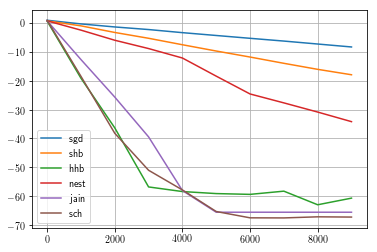

In [46]:
####################################
   ### EMERGENCY ### THIS GUY ###
####################################

#generating data 
# alpha_data = 10
# n = pow(10,5)
# d = 2
# X = alpha_data*np.ones((n,d))
# X[:,1] = 2*(np.random.randint(2,size=n)-0.5)
# Z = np.random.rand(n)
# inds = Z>pow(alpha_data,-2)
# X[inds,1] = 0
# Y = 2*(np.random.randint(2,size=n)-0.5)
# X[:,1] = Y * X[:,1] 

wst = np.random.randn(d)
wst = wst/np.linalg.norm(wst)
# wst = np.zeros(d)
# mu = np.random.randn(d)
mu = np.zeros(d)
w_sgd = np.random.randn(d)
w_sgd = w_sgd/np.linalg.norm(w_sgd)
w_shb = w_sgd.copy()
w_hhb = w_sgd.copy()


T = 10000
ss = 0.1

def get_obj(w):
  return 0.5*(w.transpose() @ S @ w) - w.transpose() @ S @ wst
dis_sgd = []
dis_shb = []
dis_hhb = []
dis_net = []
itrs = []
pastw = w_shb.copy()
pastwh = w_hhb.copy()
w_net = w_shb.copy()
y_net = w_net.copy()
betah = 1
y_past = y_net.copy()
beta = 0.9*betah
alpha = 0.9
I = np.eye(d)

w_jain = w_sgd.copy()
y_jain = w_jain.copy()
z_jain = w_jain.copy()
v_jain = w_jain.copy()

mu_jain =sigma
KK_jain = np.sqrt(sigma*3)
beta_jain = 1/9*np.power(KK_jain,1)
alpha_jain = 3*np.sqrt(5)/np.power(KK_jain,1)/(1+3*np.sqrt(5)/np.power(KK_jain,1))

jain_list = deque([])
dis_jain = []

w_sch = w_sgd.copy()
z_sch = w_sgd.copy()
v_sch = w_sgd.copy()

mu_sch = sigma
rho_sch = 2

eta_sch = 1/rho_sch
gamma_sch = 1/np.sqrt(eta_sch*mu_sch*rho_sch)
beta_sch = 1-np.sqrt(mu_sch*eta_sch/rho_sch)


dis_sch = []

for i in range(T): 
  x = X[i,:]
  y = np.dot(x,wst) #+ np.random.randn(1)*0.01
  w_sgd = w_sgd - 5*ss*(np.dot(w_sgd,x)*x-y*x)
  Q = 2*alpha
  rr = 0.9*beta
  rr2 = (Q-1)/(Q+1)
  temp = y_net.copy();
  w_net = (1+rr)*y_net - rr*y_past
  y_net = w_net - 3*ss*(np.dot(w_net,x)*x-y*x)
  y_past = temp
#   y_net = w_net - ss*S@(w_net-wst)
 
  
  shb = .1*ss
  temp = w_shb
  w_shb = w_shb - 1*shb*(np.dot(w_shb,x)*x - y*x ) +  0.99* (w_shb-pastw) # beta* (w_shb-pastw)
  pastw = temp
  temp = w_hhb.copy()
  shh = ss
  extra = w_hhb - pastwh
  rr2 = 0.9
  w_hhb = w_hhb - 2*ss*(np.dot(w_hhb+1.5*extra,x)*x - y*x ) +  0.98* (w_hhb-pastwh) #2*shh*np.outer(x,x) @ w_hhb + 2*shh*np.outer(x,x) @ pastwh 
  pastwh = temp
#   w = w - ss* ((S @ w) - S @ wst)

  sjain = 1/3/np.sqrt(5)/mu_jain*KK_jain
  djain = 1/3
  y_jain = alpha_jain * w_jain +(1-alpha_jain)*v_jain
  w_jain = y_jain - djain * (np.dot(y_jain,x)*x - y*x )
  z_jain = beta_jain *y_jain +(1-beta_jain)*v_jain
  v_jain = z_jain - sjain * (np.dot(y_jain,x)*x - y*x )

  jain_list.append(w_jain)
  #if np.array(jain_list).shape[0] == 2:
  # waste = jain_list.popleft()
    
  b_sch = np.sqrt(mu_sch)/np.power(beta_sch,(i+1)/2)
  a_sch = 1/np.power(beta_sch,(i+1)/2)
  alpha_sch = eta_sch*b_sch*b_sch*beta_sch*gamma_sch/(a_sch*a_sch+eta_sch*b_sch*b_sch*beta_sch*gamma_sch)

  tmp_w = w_sch
  w_sch = z_sch-eta_sch*(np.dot(z_sch,x)*x - y*x )
  z_sch = alpha_sch*v_sch+(1-alpha_sch)*tmp_w
  v_sch = beta_sch*v_sch+(1-beta_sch)*z_sch-gamma_sch*eta_sch*(np.dot(z_sch,x)*x - y*x )

  if i % 1000 ==0: 
    dis_sgd.append(np.linalg.norm(w_sgd-wst)**2)
    dis_shb.append(np.linalg.norm(w_shb-wst)**2)
    dis_hhb.append(np.linalg.norm(w_hhb-wst)**2)
    dis_net.append(np.linalg.norm(w_net-wst)**2)
    #dis_jain.append(np.linalg.norm(np.array(jain_list).mean()-wst)**2)
    dis_sch.append(np.linalg.norm(w_sch-wst)**2)
    dis_jain.append(np.linalg.norm(w_jain-wst)**2)
    itrs.append(i)

plt.plot(itrs,np.log(dis_sgd),label='sgd')
plt.plot(itrs,np.log(dis_shb),label='shb')
plt.plot(itrs,np.log(dis_hhb),label='hhb')
plt.plot(itrs,np.log(dis_net),label='nest')
plt.plot(itrs,np.log(dis_jain),label='jain')
plt.plot(itrs,np.log(dis_sch),label='sch')
plt.legend()
plt.grid()
# plt.savefig('extra_extrapolation.pdf',format='pdf')

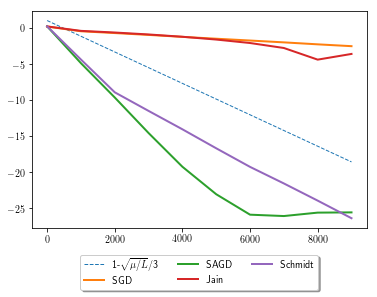

In [44]:
fig = plt.figure()
plt.rc('text', usetex=True)
# plt.plot(itrs,np.log((1-sigma)**np.asarray(itrs)),label='1-$\mu/L$',LineWidth=1)
plt.plot(itrs,np.log10(10*(1-1/alpha_data/2)**np.asarray(itrs)),label='1-$\sqrt{\mu/L}$/3',LineWidth=1,linestyle='dashed')
plt.plot(itrs,np.log10(dis_sgd),label='SGD',LineWidth=2)
plt.plot(itrs,np.log10(dis_hhb),label='SAGD',LineWidth=2)
plt.plot(itrs,np.log10(dis_jain),label='Jain',LineWidth=2)
plt.plot(itrs,np.log10(dis_sch),label='Schmidt',LineWidth=2)
lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True,ncol=3)
fig.savefig('accelerated_uniform.pdf', format = 'pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

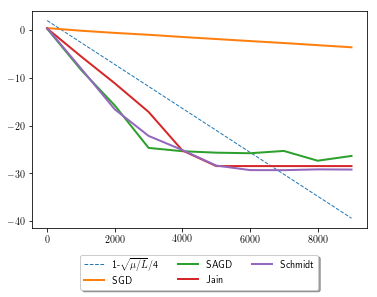

In [47]:
fig = plt.figure()
#from matplotlib import rcParams
#rcParams['text.usetex'] = True
plt.rc('text', usetex=True)
# plt.plot(itrs,np.log((1-sigma)**np.asarray(itrs)),label='1-$\mu/L$',LineWidth=1)
plt.plot(itrs,np.log10(100*(1-np.sqrt(sigma)/3)**np.asarray(itrs)),label='1-$\sqrt{\mu/L}$/4',LineWidth=1,linestyle='dashed')
plt.plot(itrs,np.log10(dis_sgd),label='SGD',LineWidth=2)
plt.plot(itrs,np.log10(dis_hhb),label='SAGD',LineWidth=2)
plt.plot(itrs,np.log10(dis_jain),label='Jain',LineWidth=2)
plt.plot(itrs,np.log10(dis_sch),label='Schmidt',LineWidth=2)
lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True,ncol=3)
fig.savefig('accelerated_gaussian.pdf', format = 'pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

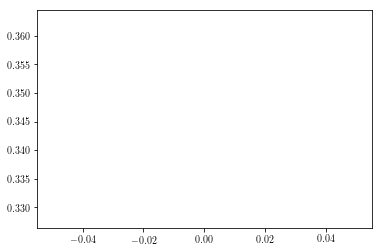

In [20]:
plt.plot(itrs,np.log10(dis_sgd),label='SGD',LineWidth=2)

In [22]:
len(dis_sgd)

20

In [33]:
dis_jain

[0.04002807701556705,
 4.4037635507449156e-07,
 1.0859810875473527e-13,
 6.930830731420634e-21,
 4.147682728232351e-26,
 1.1093356479670479e-31,
 1.1093356479670479e-31,
 0.0,
 0.0,
 0.0]